In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [2]:
FLD = "/home/nur/projects/analysis/dynamic_price/data/hw4"
!ls {FLD}

conc_df.csv	     promo_1510002.csv	   sku_dict.csv  third_group_sku.csv
first_group_sku.csv  second_group_sku.csv  test.csv


## Вендоры и Бренды

In [18]:
sku_dict = pd.read_csv(os.path.join(FLD, 'sku_dict.csv'))
sku_dict.head(2)

,sku_id,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,43207,A1,A10,A1000,A1000001,A10001,A1000001,2018-01-01,2200-01-01 00:00:00
1,87209,UA,UA1,UA100,UA10000,BLW9FG,484JDFU5,2019-09-05,2200-01-01 00:00:00


In [19]:
groups = ['first_group_sku.csv', 'second_group_sku.csv', 'third_group_sku.csv']
dflist = []
for fname in groups:
    df = pd.read_csv(os.path.join(FLD, fname))
    df['file'] = fname[:-4]
    dflist.append(df)
dfg = pd.concat(dflist, ignore_index=True)
dfg.head(2)

,dates,SKU,price_per_sku,num_purchases,file
0,2018-04-20,32950,422.975,3,first_group_sku
1,2018-04-24,32950,429.275,3,first_group_sku


In [20]:
df = dfg.merge(sku_dict, how='left', left_on = 'SKU', right_on = 'sku_id')
df.drop(['sku_id'], axis=1, inplace=True)
assert df.shape[0] == dfg.shape[0]
df.head(2)

,dates,SKU,price_per_sku,num_purchases,file,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,2018-04-20,32950,422.975,3,first_group_sku,FE,FE1,FE100,FE10000,AO59EQ,3FAIRJ4W,2018-01-15,2200-01-01 00:00:00
1,2018-04-24,32950,429.275,3,first_group_sku,FE,FE1,FE100,FE10000,AO59EQ,3FAIRJ4W,2018-01-15,2200-01-01 00:00:00


In [30]:
res = df.groupby(by='file', as_index=False)[['vendor', 'brand_code']].nunique()
res = res.rename(columns={'vendor': 'vendor_unique_number', 'brand_code': 'brand_unique_number'})

out_fpath = 'unique_vendor_brand.csv'
res.to_csv(out_fpath, index=False)

In [32]:
!cat unique_vendor_brand.csv

file,vendor_unique_number,brand_unique_number
first_group_sku,2,1
second_group_sku,9,1
third_group_sku,8,1


In [50]:
# Для каждой из групп найдите максимальную и минимальную цену для каждого SKU. 
out_fpath = "sku_min_max_prices.csv"

res = df.groupby(by='SKU', as_index=False).agg(min_price=('price_per_sku', np.min),
                                               max_price=('price_per_sku', np.max))
res.to_csv(out_fpath, index=False)

In [52]:
!head -n 2 sku_min_max_prices.csv

SKU,min_price,max_price
10334,79.15039999999998,102.781


## Анализ first_group_sku

In [13]:
df1 = df[df.file == 'first_group_sku']
df1.head(1)

,dates,SKU,price_per_sku,num_purchases,file,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,2018-04-20,32950,422.975,3,first_group_sku,FE,FE1,FE100,FE10000,AO59EQ,3FAIRJ4W,2018-01-15,2200-01-01 00:00:00


<AxesSubplot:xlabel='dates'>

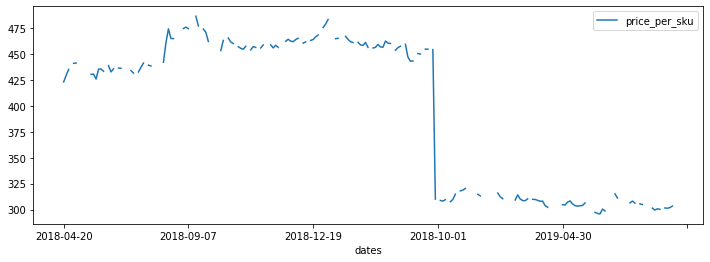

In [37]:
df1.plot(x='dates', y = 'price_per_sku', figsize=(12, 4))

In [18]:
# Посчитайте количество пропусков в столбце цен (price_per_sku) для каждого SKU
res = df1.groupby(by='SKU', as_index=False).agg(nulls_count = ('price_per_sku', lambda x: x.isnull().sum()))
res.nulls_count = res.nulls_count.astype(int)
# res = res.rename(columns={'vendor': 'vendor_unique_number', 'brand_code': 'brand_unique_number'})
out_fpath = 'first_sku_price_missings.csv'
res.to_csv(out_fpath, index=False)

In [28]:
!cat first_sku_price_missings.csv

SKU,nulls_count
32950,44
78833,32


In [31]:
df.price_per_sku.isnull().any()

True

<AxesSubplot:xlabel='dates'>

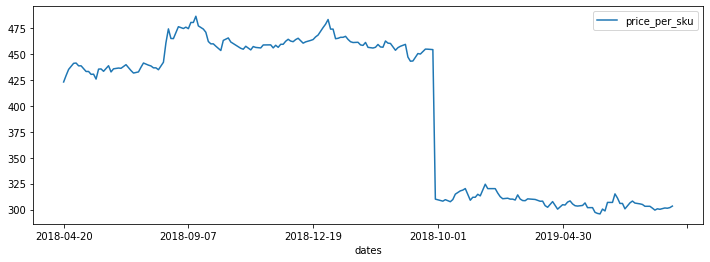

In [36]:
# Предложите вариант заполнения пропусков в данных.
def price_imputation(d):
    d = d.copy()
    d.loc[d.price_per_sku.isnull(), 'price_per_sku'] = (d.price_per_sku.fillna(method='ffill')
                                                    + d.price_per_sku.fillna(method='bfill'))/2
    return d

price_imputation(df1).plot(x='dates', y = 'price_per_sku', figsize=(12, 4))

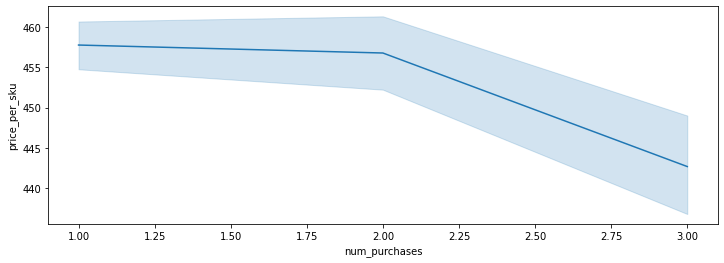

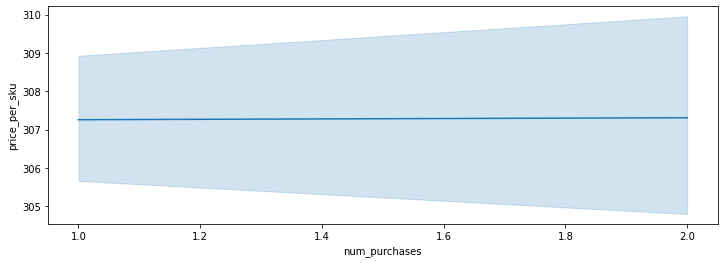

In [27]:
# Для каждого SKU постройте график эластичности спроса
for sku in df1.SKU.unique():
    plt.figure(figsize=(12, 4))
    sns.lineplot(x=df1[df1.SKU == sku].num_purchases, 
             y=df1[df1.SKU == sku].price_per_sku)

## Анализ second_group_sku

In [193]:
df2 = df[df.file == 'second_group_sku'].copy()
df2['dates'] = pd.to_datetime(df2.dates)
df2['week_num'] = df2.dates.dt.isocalendar().week.astype(int)
df2['year'] = df2.dates.dt.year
df2.head(1)

,dates,SKU,price_per_sku,num_purchases,file,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date,week_num,year
245,2018-04-19,10334,92.89,10,second_group_sku,15,151,15100,1510002,4HJSP5,79VL731U,2018-04-19,2200-01-01 00:00:00,16,2018


In [12]:
pivot_t = df2.pivot_table(index='dates', columns='SKU', values='price_per_sku')
pivot_t.tail(2)

SKU,10334,17812,36096,38767,43678,57561,64619,68211,69997,72784,83329,90611,98255
dates,,,,,,,,,,,,,
2019-12-23,101.094,NaN,NaN,74.536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-24,101.094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='dates'>

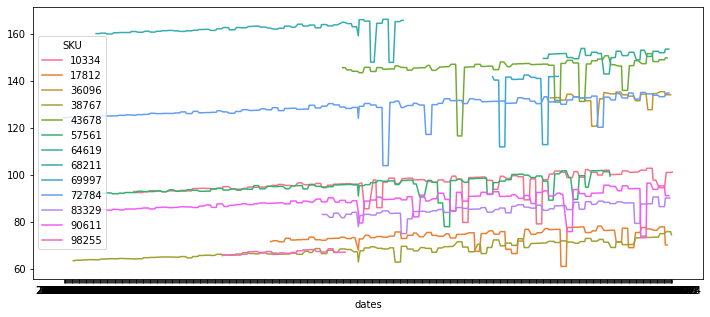

In [10]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=pivot_t, dashes=False)

In [194]:
dp = pd.read_csv(os.path.join(FLD, 'promo_1510002.csv'))
dp.head(2)

,year,week_num,SKU,discount
0,2019,1,90611,0.9
1,2019,2,10334,0.9


In [195]:
df2 = df2.merge(dp, how='left', on = ['SKU', 'year', 'week_num'])
df2.head(1)

,dates,SKU,price_per_sku,num_purchases,file,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date,week_num,year,discount
0,2018-04-19,10334,92.89,10,second_group_sku,15,151,15100,1510002,4HJSP5,79VL731U,2018-04-19,2200-01-01 00:00:00,16,2018,NaN


In [65]:
# количество записей (строк) с промоакциями
fpath_out = "second_sku_promo_count.csv"
res = dp.SKU.value_counts()
pd.DataFrame.from_dict({"SKU": res.index, 'promo_count': res.values}).to_csv(fpath_out, index=False)

In [66]:
!head second_sku_promo_count.csv

SKU,promo_count
17812,8
10334,8
57561,7
90611,6
38767,5
43678,4
36096,3
83329,3
72784,3


In [197]:
df2['is_discount'] = np.where(df2.discount.isnull(), 0,1)

In [216]:
res1 = df2[df2.is_discount==0].groupby(by=['SKU'], as_index=False).agg(mean_num_purchases_wo_promo = ('num_purchases', np.mean))
res2 = df2[df2.is_discount==1].groupby(by=['SKU'], as_index=False).agg(mean_num_purchases_promo = ('num_purchases', np.mean))
res = res2.merge(res1, how='outer', on = ['SKU'])
# res.fillna(0, inplace=True)
res

,SKU,mean_num_purchases_promo,mean_num_purchases_wo_promo
0,10334,11.977778,9.980050
1,17812,5.934783,3.613636
2,36096,12.923077,11.414634
3,38767,10.222222,9.000000
4,43678,12.090909,9.448276
5,57561,9.727273,8.050378
6,64619,5.800000,4.329897
7,68211,13.111111,11.459350
8,69997,7.818182,4.333333
9,72784,9.133333,6.953782


In [217]:
# среднее количество продаж в период с промоакциями и в период без них.

fpath_out = "second_sku_sales_comparison.csv"
res.to_csv(fpath_out, index=False)

In [218]:
!cat second_sku_sales_comparison.csv

SKU,mean_num_purchases_promo,mean_num_purchases_wo_promo
10334,11.977777777777778,9.980049875311721
17812,5.934782608695652,3.6136363636363638
36096,12.923076923076923,11.414634146341463
38767,10.222222222222221,9.0
43678,12.090909090909092,9.448275862068966
57561,9.727272727272727,8.05037783375315
64619,5.8,4.329896907216495
68211,13.11111111111111,11.459349593495935
69997,7.818181818181818,4.333333333333333
72784,9.133333333333333,6.953781512605042
83329,11.866666666666667,9.416974169741698
90611,6.903225806451613,4.993039443155452
98255,,7.593406593406593


## Анализ third_group_sku

In [172]:
df3 = df[df.file == 'third_group_sku'].copy()
df3['dates'] = pd.to_datetime(df3.dates)
df3['week_num'] = df3.dates.dt.isocalendar().week.astype(int)
df3['year'] = df3.dates.dt.year
df3.head(1)

,dates,SKU,price_per_sku,num_purchases,file,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date,week_num,year
3994,2018-04-22,11050,101.575,10,third_group_sku,15,151,15100,1510003,CHQKSO,WKXRWTP7,2018-04-21,2200-01-01 00:00:00,16,2018


In [136]:
pivot_t = df3.pivot_table(index='dates', columns='SKU', values='price_per_sku')
pivot_t.tail(1)

SKU,11050,19632,24125,49661,54404,60870,80308,80631,84395,89272
dates,,,,,,,,,,
2019-12-24,NaN,NaN,NaN,165.978,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='dates'>

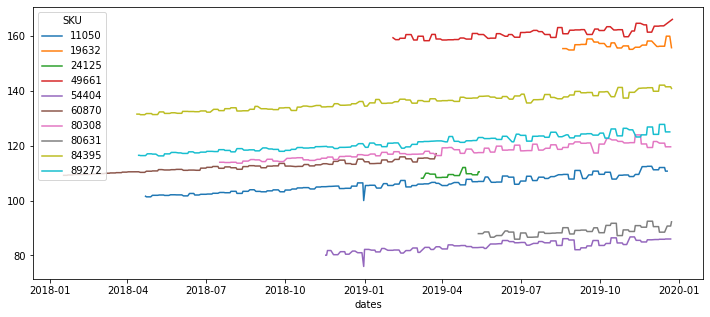

In [137]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=pivot_t, dashes=False)

In [222]:
conc = pd.read_csv(os.path.join(FLD, 'conc_df.csv'))
conc.head(2)

,SKU,year,week_num,ret_net_code,price_per_sku
0,84395,2019,18,1,164.694
1,84395,2019,18,2,164.694


In [224]:
aggr_conc = conc.groupby(['SKU', 'year', 'week_num']).price_per_sku.agg(['min', 'max']).reset_index()

In [226]:
df3 = df3.merge(aggr_conc, how='left', on=['SKU', 'year', 'week_num'])
df3.head(2)

,dates,SKU,price_per_sku,num_purchases,file,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date,week_num,year,is_less,min,max
0,2018-04-22,11050,101.575,10,third_group_sku,15,151,15100,1510003,CHQKSO,WKXRWTP7,2018-04-21,2200-01-01 00:00:00,16,2018,False,NaN,NaN
1,2018-04-23,11050,101.344,9,third_group_sku,15,151,15100,1510003,CHQKSO,WKXRWTP7,2018-04-21,2200-01-01 00:00:00,17,2018,False,NaN,NaN


In [174]:
# количество записей в таблице цен конкурентов
res = conc.SKU.value_counts()
fpath_out = "third_sku_competitor_count.csv"
pd.DataFrame.from_dict({"SKU": res.index, 'conc_rows_count': res.values}).to_csv(fpath_out, index=False)

In [175]:
!cat third_sku_competitor_count.csv

SKU,conc_rows_count
80308,453
84395,399
89272,396
49661,387
54404,384
11050,384
80631,261
19632,147
60870,105
24125,93


In [227]:
# количество записей в моменты, когда цена на SKU была меньше или равна минимальной цене на
# этот же SKU у конкурентов

df3['is_less'] = np.where(df3.price_per_sku <= df3['min'], 1,0)
res = df3.groupby(by='SKU', as_index=False).agg(lowest_price_rows_count =('is_less', np.sum))

fpath_out = "third_sku_le_price.csv"
res.to_csv(fpath_out, index=False)

In [228]:
!cat third_sku_le_price.csv

SKU,lowest_price_rows_count
11050,0
19632,0
24125,0
49661,3
54404,13
60870,0
80308,0
80631,0
84395,14
89272,7


## Предсказание цены на будущее для SKU из тестового набора данных

In [8]:
dftest = pd.read_csv(os.path.join(FLD, 'test.csv'))
dftest.head(2)

,dates,SKU
0,2018-12-17,98255
1,2018-12-21,98255


In [14]:
from IPython.display import display, Math, Latex
display(Math(r'E_{p}(D)=\dfrac{\delta Q_d}{\delta P}\dfrac{P}{Q_d}'))
# коэффициент эластичности товаров

<IPython.core.display.Math object>

In [21]:
df.dates = pd.to_datetime(df.dates)

In [23]:
df[['dates', 'SKU', 'price_per_sku', 'num_purchases']].head(2)

,dates,SKU,price_per_sku,num_purchases
0,2018-04-20,32950,422.975,3
1,2018-04-24,32950,429.275,3


In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
df.dates.min(), df.dates.max()

(Timestamp('2018-01-17 00:00:00'), Timestamp('2019-12-24 00:00:00'))

In [26]:
dftest.dates.min(), dftest.dates.max()

('2018-12-17', '2019-12-31')

In [28]:
predictions = {}
for sku in df.SKU.unique():
    print(df[df.SKU == sku].dates.min(), df[df.SKU == sku].dates.max())
    print(dftest[dftest.SKU == sku].dates.min(), dftest[dftest.SKU == sku].dates.max())
    print()
    train_data = df[df.SKU == sku].price_per_sku.values
    MA = ARIMA(train_data, order=(0,0,20))
    MA_model = MA.fit()
    predictions[sku] = MA_model.predict(start = len(train_data), end= len(train_data) + 7-1)

2018-04-20 00:00:00 2019-04-09 00:00:00
2019-04-10 2019-04-21



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/home/nur/projects/analysis/env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

2018-09-28 00:00:00 2019-12-03 00:00:00
2019-12-17 2019-12-28



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2018-04-19 00:00:00 2019-12-24 00:00:00
2019-12-25 2019-12-31

2018-09-22 00:00:00 2019-12-18 00:00:00
2019-12-21 2019-12-31

2019-08-07 00:00:00 2019-12-22 00:00:00
2019-12-23 2019-12-29



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2018-02-09 00:00:00 2019-12-23 00:00:00
2019-12-24 2019-12-31

2018-12-13 00:00:00 2019-12-18 00:00:00
2019-12-20 2019-12-31

2018-02-10 00:00:00 2019-10-14 00:00:00
2019-10-16 2019-10-28

2019-07-30 00:00:00 2019-12-20 00:00:00
2019-12-21 2019-12-29



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2018-03-07 00:00:00 2019-02-20 00:00:00
2019-02-21 2019-03-01



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


2019-06-02 00:00:00 2019-08-16 00:00:00
2019-08-17 2019-08-29



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2018-01-24 00:00:00 2019-12-20 00:00:00
2019-12-21 2019-12-27

2018-11-20 00:00:00 2019-12-21 00:00:00
2019-12-22 2019-12-31

2018-03-02 00:00:00 2019-12-20 00:00:00
2019-12-22 2019-12-31

2018-07-29 00:00:00 2018-12-16 00:00:00
2018-12-17 2018-12-26



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2018-04-22 00:00:00 2019-12-18 00:00:00
2019-12-20 2019-12-30

2019-08-19 00:00:00 2019-12-23 00:00:00
2019-12-24 2019-12-31



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


2019-03-08 00:00:00 2019-05-14 00:00:00
2019-05-16 2019-05-24



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2019-02-03 00:00:00 2019-12-24 00:00:00
2019-12-25 2019-12-31

2018-11-17 00:00:00 2019-12-22 00:00:00
2019-12-24 2019-12-31

2018-01-17 00:00:00 2019-03-25 00:00:00
2019-03-26 2019-04-02



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2018-07-17 00:00:00 2019-12-22 00:00:00
2019-12-25 2019-12-31



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2019-05-13 00:00:00 2019-12-23 00:00:00
2019-12-24 2019-12-31



/home/nur/projects/analysis/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2018-04-12 00:00:00 2019-12-23 00:00:00
2019-12-24 2019-12-31

2018-04-14 00:00:00 2019-12-21 00:00:00
2019-12-22 2019-12-31



In [42]:
np.mean(df[df.SKU == 78833]).price_per_sku

/home/nur/projects/analysis/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


307.276171875

In [29]:
predictions

{32950: array([450.24247618, 449.5186504 , 449.35810696, 453.20410233,
        455.87336856, 453.99605238, 454.6751741 ]),
 78833: array([nan, nan, nan, nan, nan, nan, nan]),
 10334: array([99.82589389, 98.99996326, 99.03577764, 98.40937222, 97.05586184,
        97.49278531, 97.27589736]),
 17812: array([70.04250255, 69.82091544, 70.07833822, 69.94490655, 73.38572115,
        73.20265929, 73.23294259]),
 36096: array([131.54140301, 132.53392926, 130.62829051, 131.02981201,
        130.84860981, 130.12670048, 130.37807038]),
 38767: array([74.19163981, 73.47504103, 72.87412986, 72.41068478, 72.52849103,
        72.72975703, 72.77332915]),
 43678: array([149.16847832, 147.6172817 , 146.89343158, 145.6500468 ,
        144.97129146, 144.06958772, 144.12734663]),
 57561: array([97.97419083, 96.67900163, 95.80703488, 94.8588304 , 95.46012769,
        95.93603591, 94.74944099]),
 64619: array([153.12805856, 152.44023673, 152.45096637, 151.48911384,
        149.91930817, 149.7492386 , 149.0844

In [36]:
dftest['price_per_sku'] = 0
for sku in dftest.SKU.unique():
    dftest.loc[dftest.SKU == sku, 'price_per_sku' ] = predictions[sku]
dftest

,dates,SKU,price_per_sku
0,2018-12-17,98255,67.479134
1,2018-12-21,98255,67.616843
2,2018-12-22,98255,67.738410
3,2018-12-23,98255,67.438382
4,2018-12-24,98255,67.676674
...,...,...,...
170,2019-12-31,80631,90.016833
171,2019-12-31,19632,156.462027
172,2019-12-31,84395,137.991576
173,2019-12-31,43678,144.127347


In [43]:
dftest.fillna(307.276171875, inplace=True)

In [48]:
dftest.price_per_sku.isnull().any()

False

In [44]:
fpath_out = "prediction.csv"
# RMSE ≤ 15
dftest.to_csv(fpath_out, index=None)

In [45]:
!head prediction.csv

dates,SKU,price_per_sku
2018-12-17,98255,67.4791337076447
2018-12-21,98255,67.61684309735271
2018-12-22,98255,67.73841036303345
2018-12-23,98255,67.4383815093166
2018-12-24,98255,67.67667393771185
2018-12-25,98255,67.45371092166454
2018-12-26,98255,67.23868837517503
2019-02-21,68211,163.94204245124996
2019-02-22,68211,165.65625829111158


In [46]:
!explorer.exe .